In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import operator
import numbers
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = '/Users/leo/Desktop/DSGA_1007/Project/'

In [3]:
full_data = pd.read_csv(path + 'Most-Recent-Cohorts-All-Data-Elements.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,9,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1008,1009,1010,1011,1014,1015,1016,1017,1018,1019,1021,1022,1023,1027,1028,1029,1030,1031,1032,1034,1035,1036,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1065,1066,1067,1068,1069,1070,1071,1073,1074,1075,1076,1078,1079,1080,1081,1082,1083,1084,1086,1087,1088,1089,1091,1092,1093,1094,1095,1096,1097,1099,1100,1101,1102,1104,1105,1106,1107,1108,1109,1110,1112,1113,1114,1115,1118,1119,1121,1122,1123,1125,1127,1128,1131,1132,1134,1135,1136,1138,1140,1141,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1170,1171,1172,1173,1174,1175,1177,1178,1179,1180,1183,1184,1185,1186,1187,1188,1190,1192,1196,1199,1200,1201,1209,1212,1213,1214,1222,1223,1224,1225,1226,1227,1235,1236,1237,123

In [4]:
full_data.shape

(7175, 1899)

In [5]:
def normalizeColumn(column, data):
    if isinstance(data[column][0], numbers.Number):
        return [float(i)/sum(data[column].values) for i in data[column].values]
    else:
        return data[column]

def normalizeData(data):
    for column in data.columns:
        data[column] = normalizeColumn(column, data)
    return data

def cleanColumn(column, data):
    if type(data[column][0]) == type('.'):
        data[column][data[column] == 'PrivacySuppressed'] = np.nan
    return data[column]

def cleanData(data):
    for column in data.columns:
        data[column] = cleanColumn(column, data)
    return data

def imputeValue(column, data):
    column_data = pd.to_numeric(data[column])
    column_mean = column_data.mean()
    for i, row in enumerate(column_data):
        if np.isnan(row):
            column_data.iloc[i] = column_mean
    return column_data

def imputeNumeric(columns, data):
    for column in columns:
        data[column] = imputeValue(column, data)
    return data

def processCategorical(columns, data):
    for column in columns:
        data[column] = data[column].astype('category')
    return data

In [6]:
def calculateCostEarning(data):
    cost_a = list(data['COSTT4_A'])
    cost_p = list(data['COSTT4_P'])
    cost = []
    for i in range(len(cost_a)):
        if not np.isnan(cost_a[i]):
            if not np.isnan(cost_p[i]):
                raise Exception('No school is like this')
            cost.append(cost_a[i])
        else:
            cost.append(cost_p[i])
    earning = data['MD_EARN_WNE_P6'] 
    return pd.DataFrame({'cost':cost, 'earning':earning})

def calculateC100(data):
    target_C100 = []
    C100_4 = data['C100_4']
    C100_L4 = data['C100_L4']
    data = data.drop(['C100_4', 'C100_L4'], 1)
    for i in range(len(C100_4)):
        if not np.isnan(C100_4[i]):
            if not np.isnan(C100_L4[i]):
                raise Exception('No school is like this')
            target_C100.append(C100_4[i])
        else:
            target_C100.append(C100_L4[i])
    data['C100_4'] = target_C100
    return data

def fillMean(data):
    data['AVGFACSAL'].fillna((data['AVGFACSAL'].mean()), inplace=True)
    data['UG'].fillna((data['UG'].mean()), inplace=True)
    data['PFTFAC'].fillna((data['PFTFAC'].mean()), inplace=True)
    data['UGDS_MEN'].fillna((data['UGDS_MEN'].mean()), inplace=True)
    data['UGDS_WOMEN'].fillna((data['UGDS_WOMEN'].mean()), inplace=True)
    return data

def fillIncome(data):
    income = {1: 44765, 2:73355, 4: 51492, 5: 41995, 6:64500, 8:63909, 9:71346,
              10:61255, 11:75628,12: 49426, 13: 51244, 15: 73486, 16: 48275, 
              17:59588, 18: 50532, 19:54736, 20: 53906, 21: 45215, 22:45727,
             23:51494, 24:75847, 25:70628 , 26:51084, 27:63488,
             28: 40593, 29:50238, 30:49509, 31:54996, 32:52431,
             33: 70303, 34:72222, 35: 45382, 36:60850, 37:47830,
             38: 60577, 39:51075, 40:48568, 41:54148, 42:55702,
             44: 58073, 45:47238, 46: 53017, 47: 47275, 48:55653,
             49: 62912, 50: 56990, 51: 66262, 53:64129, 54:42019,
             55: 55638, 56: 60214}
    data['ST_FIPS'] = data['ST_FIPS'].astype(float)
    data['MEDIAN_HH_INC'].fillna(data.ST_FIPS.map(income), inplace=True)
    data['MEDIAN_HH_INC'] = data['MEDIAN_HH_INC'].astype(float)
    data['MEDIAN_HH_INC'].fillna(data['MEDIAN_HH_INC'].mean(), inplace=True)
    return data

##HISP: Hispanic students rose from 4 percent to 17 percent 
# API: Asian/Pacific Islander students rose from 2 percent to 7 percent
# Black: The percentage of Black students increased from 10 percent in 1976 to 14 percent in 2015
# White: 58%
def fillRace(data):
    data['UG_NRA'].fillna(0.01, inplace=True)
    data['UG_WHITENH'].fillna(0.58, inplace=True)
    data['UG_BLACKNH'].fillna(0.14, inplace=True)
    data['UG_API'].fillna(0.035, inplace=True)
    data['UG_AIANOLD'].fillna(0.035, inplace=True)
    data['UG_HISPOLD'].fillna(0.17, inplace=True)
    data['UG_UNKN'].fillna((1 - data['UG_NRA'] - 
                                data['UG_WHITENH'] - 
                                data['UG_BLACKNH'] - 
                                data['UG_API'] - 
                                data['UG_AIANOLD'] - 
                                data['UG_HISPOLD']),inplace=True)
    return data

def fillUnemp(data):
    unemp = {1: 3.8, 2:7.3, 4: 4.9, 5: 3.8, 6:4.3, 8:3.0, 9:4.5, 
             10:4.3, 11:5.6,12: 3.9, 13: 4.4, 15: 2.1, 16: 2.9, 17:4.6, 
             18: 3.2, 19:2.8, 20: 3.4, 21: 4.0, 22:4.4,
             23:2.7, 24:4.3, 25:3.5 , 26:4.7, 27:3.2,
             28: 4.5, 29:3.6, 30:4.1, 31:2.8, 32:4.9,
             33: 2.6, 34:4.6, 35: 5.6, 36:4.6, 37:4.5,
             38: 2.6, 39:4.4, 40:4.0, 41:4.1, 42:4.8,
             44: 4.5, 45:4.4, 46: 3.4, 47: 3.4, 48:4.0,
             49: 3.1, 50: 2.8, 51: 3.4, 53:4.8, 54:5.4,
             55: 2.9, 56: 3.9, 60:18, 66:4.4, 69:11.2, 72:8.8, 78:9.2}
    data['ST_FIPS'] = data['ST_FIPS'].astype(float)
    data['UNEMP_RATE'].fillna(data.ST_FIPS.map(unemp), inplace=True)
    data['UNEMP_RATE'] = data['UNEMP_RATE'].astype(float)
    data['UNEMP_RATE'].fillna(data['UNEMP_RATE'].mean(), inplace=True)
    return data

def calculateROI(data):
    data['cost'] = data['cost'].astype('int64')
    data['earning'] = data['earning'].astype('int64')
    data['ROI'] = (data['earning'])/data['cost']
    data.drop(['cost', 'earning'], 1, inplace=True)
    return data

## Feature Selection

In [7]:
features = []

admin_features = ['ADM_RATE', 'SAT_AVG']
complete_features = ['D100_4', 'D100_L4', 'C100_4', 'C100_L4']
root_features = ['LATITUDE', 'LONGITUDE']
school_features = ['REGION', 'LOCALE', 'ACCREDAGENCY', 'SCH_DEG', 'MAIN', 'NUMBRANCH', 
                   'HIGHDEG', 'CONTROL', 'ST_FIPS', 'AVGFACSAL', 'PFTFAC','ICLEVEL']
student_features = ['UG', 'UG_NRA', 'UG_UNKN', 'UG_WHITENH', 'UG_BLACKNH', 'UG_API', 'UG_AIANOLD', 
                    'UG_HISPOLD', 'APPL_SCH_PCT_GE2', 'APPL_SCH_PCT_GE3', 'APPL_SCH_PCT_GE4', 'APPL_SCH_PCT_GE5', 
                    'MEDIAN_HH_INC', 'UNEMP_RATE', 'UGDS_MEN', 'UGDS_WOMEN','UGNONDS','GRADS']

features.extend(admin_features)
features.extend(complete_features)
features.extend(root_features)
features.extend(school_features)
features.extend(student_features)


data = full_data[features]

cost_earning_df = calculateCostEarning(full_data)
data['cost'] = cost_earning_df['cost']
data['earning'] = cost_earning_df['earning']
data = cleanData(data)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [8]:
data.shape

(7175, 40)

## Fill NA values

In [9]:
nacount = pd.DataFrame(data.isna().sum())

In [10]:
nacount.columns = ['Count']

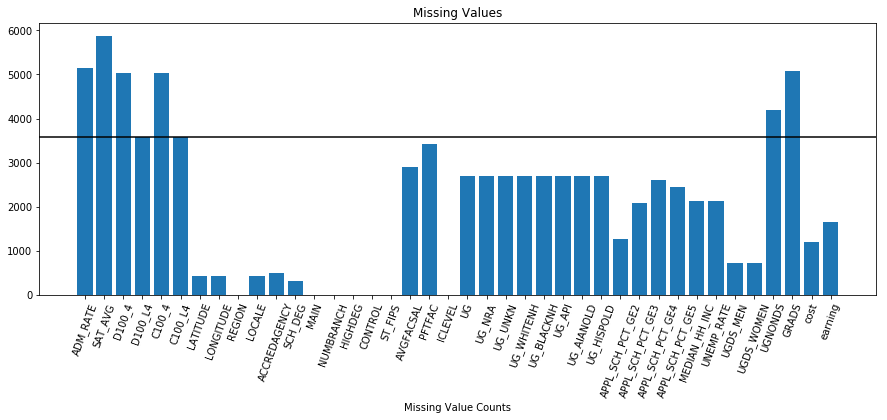

In [11]:
plt.figure(figsize = (15,5))
plt.bar(nacount.index,height = nacount['Count'])
plt.xticks(rotation=70)
plt.xlabel('Missing Value Counts')
plt.title('Missing Values')
plt.axhline(y=7175/2, color='black', linestyle='-')
plt.show()

In [12]:
# We drop these variables because over 50% data in those variables are missing and some of the columns are impossible
# to compute or fill in with mean value. So we decide to drop as well at this stage
features_drop = ['ADM_RATE', 'SAT_AVG','D100_4', 'D100_L4', 'APPL_SCH_PCT_GE2', 'APPL_SCH_PCT_GE3', 'APPL_SCH_PCT_GE4', 
                 'APPL_SCH_PCT_GE5', 'UGNONDS','GRADS', 'ACCREDAGENCY', 'CONTROL']
data = data.drop(features_drop, 1)

In [13]:
data.columns

Index(['C100_4', 'C100_L4', 'LATITUDE', 'LONGITUDE', 'REGION', 'LOCALE',
       'SCH_DEG', 'MAIN', 'NUMBRANCH', 'HIGHDEG', 'ST_FIPS', 'AVGFACSAL',
       'PFTFAC', 'ICLEVEL', 'UG', 'UG_NRA', 'UG_UNKN', 'UG_WHITENH',
       'UG_BLACKNH', 'UG_API', 'UG_AIANOLD', 'UG_HISPOLD', 'MEDIAN_HH_INC',
       'UNEMP_RATE', 'UGDS_MEN', 'UGDS_WOMEN', 'cost', 'earning'],
      dtype='object')

In [14]:
numeric_corr = ['NUMBRANCH', 'AVGFACSAL','PFTFAC', 'UG', 'UG_NRA', 'UG_UNKN', 'UG_WHITENH',
       'UG_BLACKNH', 'UG_API', 'UG_AIANOLD', 'UG_HISPOLD', 'MEDIAN_HH_INC','UNEMP_RATE', 'UGDS_MEN', 'UGDS_WOMEN']

In [15]:
data['MEDIAN_HH_INC'].isna().sum()

2123

[Text(0.5,0,'NUMBRANCH'),
 Text(1.5,0,'AVGFACSAL'),
 Text(2.5,0,'PFTFAC'),
 Text(3.5,0,'UG'),
 Text(4.5,0,'UG_NRA'),
 Text(5.5,0,'UG_UNKN'),
 Text(6.5,0,'UG_WHITENH'),
 Text(7.5,0,'UG_BLACKNH'),
 Text(8.5,0,'UG_API'),
 Text(9.5,0,'UG_AIANOLD'),
 Text(10.5,0,'UG_HISPOLD'),
 Text(11.5,0,'UGDS_MEN'),
 Text(12.5,0,'UGDS_WOMEN')]

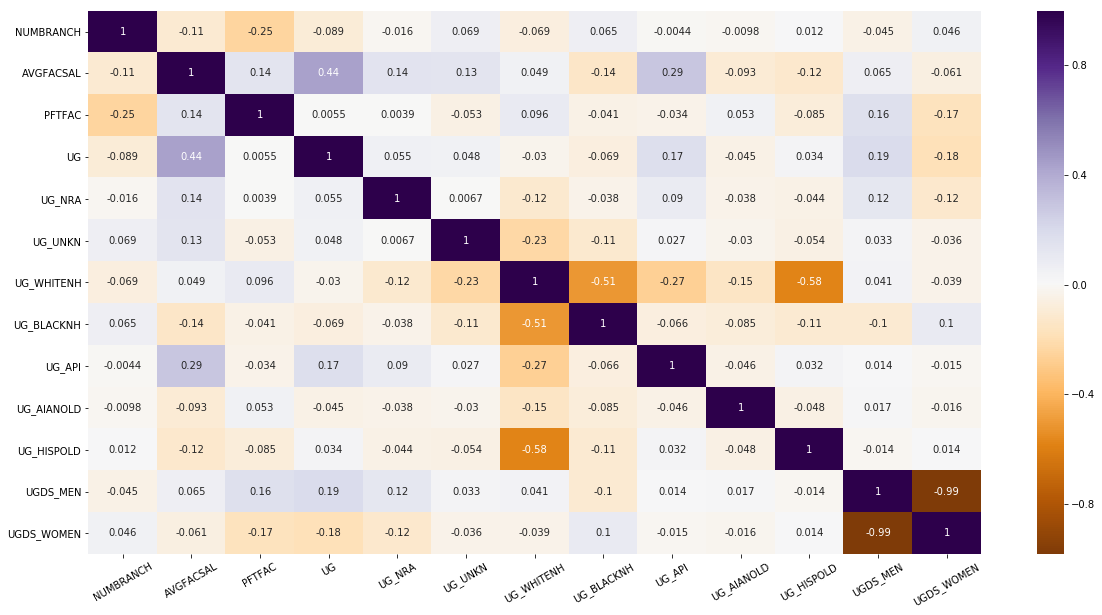

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(data[numeric_corr].corr(), ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)

In [17]:
numeric_columns = ['LATITUDE', 'LONGITUDE', 'NUMBRANCH', 'C100_4']

categorical_column = ['REGION', 'LOCALE', 'SCH_DEG', 'MAIN', 'HIGHDEG', 'ST_FIPS', 'ICLEVEL']

Y_column = ['earning', 'cost']

data = calculateC100(data)
data = imputeNumeric(numeric_columns, data)
data = fillMean(data)
data = fillRace(data)
data = fillIncome(data)
data = fillUnemp(data)
data = processCategorical(categorical_column, data)
data.dropna(inplace=True)
data = calculateROI(data)

In [18]:
data.shape

(4885, 26)

In [19]:
numeric_features = ['LATITUDE', 'LONGITUDE', 'NUMBRANCH', 'C100_4']

In [21]:
x = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 
       23, 24, 25, 26, 27, 28, 29, 30, 31]
x.extend([i for i in range(32,51)])
x.extend([51,53,54,55,56,60,64,66,69,70,72,78])

In [23]:
x.remove(43)

In [24]:
classes = ['Alabama','Alaska', 'Arizona', 'Arkansas', 'California','Colorado','Connecticut','Delaware','District of Columbia',
     'Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky',
     'Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi',
     'Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
     'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania',
     'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
     'Virginia','Washington','West Virginia','Wisconsin','Wyoming','American Samoa','Federated States of Micronesia',
'Guam','Northern Mariana Islands','Palau','Puerto Rico','Virgin Islands']

In [25]:
mapdict = dict(zip(x,classes))

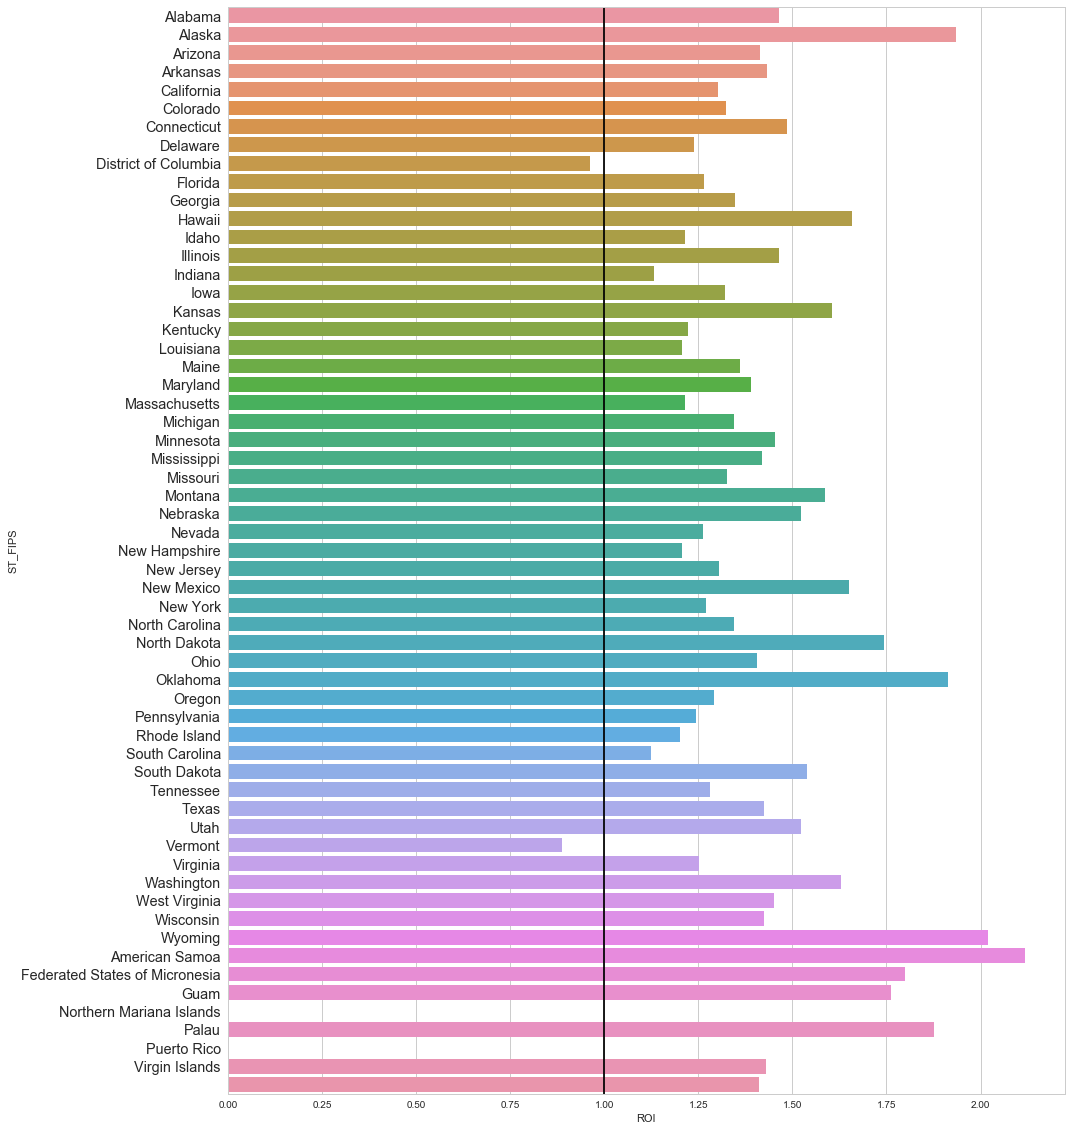

In [195]:
import seaborn as sns 
ROI_X = data.sort_values("ROI", ascending=False).reset_index(drop=True)
f, ax = plt.subplots(figsize=(15, 20)) 

g = sns.barplot(y = ROI_X['ST_FIPS'], x = ROI_X['ROI'], ci=None)
ax.axvline(x=1, color='black', linestyle='-')
ax.set_yticklabels(classes, rotation='horizontal', fontsize='large')

plt.savefig(path+'plot/state.png')
plt.show()


In [27]:
data.isna().sum()

LATITUDE         0
LONGITUDE        0
REGION           0
LOCALE           0
SCH_DEG          0
MAIN             0
NUMBRANCH        0
HIGHDEG          0
ST_FIPS          0
AVGFACSAL        0
PFTFAC           0
ICLEVEL          0
UG               0
UG_NRA           0
UG_UNKN          0
UG_WHITENH       0
UG_BLACKNH       0
UG_API           0
UG_AIANOLD       0
UG_HISPOLD       0
MEDIAN_HH_INC    0
UNEMP_RATE       0
UGDS_MEN         0
UGDS_WOMEN       0
C100_4           0
ROI              0
dtype: int64

In [28]:
data.shape

(4885, 26)

In [29]:
# UG contain zero values that should be dropped
data = data[data['UG'] != 0]

In [30]:
data.shape

(4876, 26)

In [31]:
# Drop UGDS_MEN since it is perfectly correlated with UGDS_WOMEN

data = data.drop('UGDS_MEN', 1)

In [32]:
data.shape

(4876, 25)

## Linear Model

(array([1.300e+01, 1.530e+02, 9.300e+02, 2.806e+03, 7.040e+02, 2.000e+02,
        5.000e+01, 1.400e+01, 4.000e+00, 2.000e+00]),
 array([-10.00541217,  -9.64254365,  -9.27967513,  -8.9168066 ,
         -8.55393808,  -8.19106956,  -7.82820104,  -7.46533252,
         -7.10246399,  -6.73959547,  -6.37672695]),
 <a list of 10 Patch objects>)

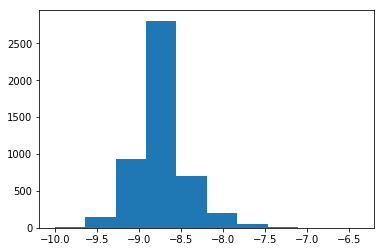

In [33]:
# Do transformation on AVGFASCAL by log(1/x)
plt.hist(np.log(1/data['AVGFACSAL']))

(array([3463.,  411.,  203.,  171.,  236.,  169.,  101.,   58.,   49.,
          15.]),
 array([0.        , 0.43438054, 0.86876108, 1.30314163, 1.73752217,
        2.17190271, 2.60628325, 3.0406638 , 3.47504434, 3.90942488,
        4.34380542]),
 <a list of 10 Patch objects>)

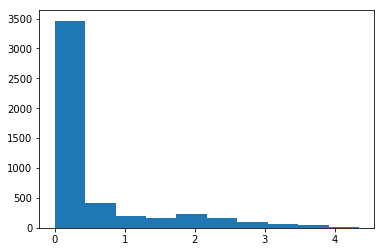

In [34]:
# Do transformation on NUMBRANCH by log(x)
plt.hist(np.log(data['NUMBRANCH']))

(array([  19.,  107.,  351.,  452.,  441.,  627., 1780.,  619.,  381.,
          99.]),
 array([ 1.79175947,  2.68801999,  3.58428052,  4.48054104,  5.37680157,
         6.27306209,  7.16932262,  8.06558314,  8.96184366,  9.85810419,
        10.75436471]),
 <a list of 10 Patch objects>)

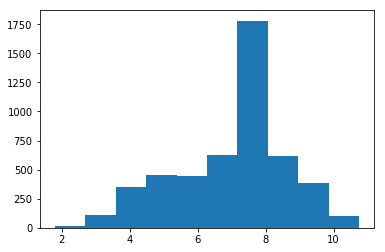

In [35]:
# Do transformation on UG by log(x)
plt.hist(np.log(data['UG']))

Text(0.5,1,'Distribution of Unemployment Rate before doing transformation')

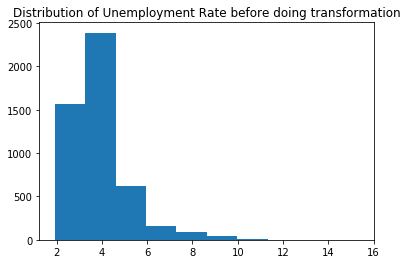

In [36]:
plt.hist(data['UNEMP_RATE'])
plt.title('Distribution of Unemployment Rate before doing transformation')

Text(0.5,1,'Distribution of Unemployment Rate after doing transformation')

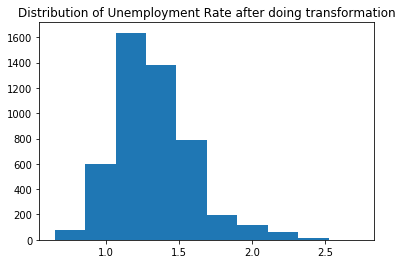

In [37]:
# Do transformation on UG by log(x)
plt.hist(np.log(data['UNEMP_RATE']))
plt.title('Distribution of Unemployment Rate after doing transformation')

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
X = data.drop('ROI', 1)
y = data['ROI']

# Transformation on X
X['UNEMP_RATE'] = np.log(X['UNEMP_RATE'])
X['UG'] = np.log(X['UG'])
X['NUMBRANCH'] = np.log(X['NUMBRANCH'])
X['AVGFACSAL'] = np.log(1/X['AVGFACSAL'])



In [43]:
# Create dummy variables
X_region = pd.get_dummies(X['REGION'], prefix='REGION', drop_first= True)
X = X.drop('REGION',1)
X = pd.concat([X,X_region],axis=1)

X_locale = pd.get_dummies(X['LOCALE'], prefix='LOCALE', drop_first= True)
X = X.drop('LOCALE',1)
X = pd.concat([X,X_locale],axis=1)

X_schdeg = pd.get_dummies(X['SCH_DEG'], prefix='SCH_DEG', drop_first= True)
X = X.drop('SCH_DEG',1)
X = pd.concat([X,X_schdeg],axis=1)

X_highdeg = pd.get_dummies(X['HIGHDEG'], prefix='HIGHDEG', drop_first= True)
X = X.drop('HIGHDEG',1)
X = pd.concat([X,X_highdeg],axis=1)

X_main = pd.get_dummies(X['MAIN'], prefix='MAIN', drop_first= True)
X = X.drop('MAIN',1)
X = pd.concat([X,X_main],axis=1)

X_stfips = pd.get_dummies(X['ST_FIPS'], prefix='ST_FIPS', drop_first= True)
X = X.drop('ST_FIPS',1)
X = pd.concat([X,X_stfips],axis=1)

X_iclevel = pd.get_dummies(X['ICLEVEL'], prefix='ICLEVEL', drop_first= True)
X = X.drop('ICLEVEL',1)
X = pd.concat([X,X_iclevel],axis=1)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

linear = LinearRegression()
linear = linear.fit(X, y)

coef = linear.coef_

In [48]:
feature_dict = dict(zip(data.columns, coef))
feature_dict = sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=1)
feature_dict

[('MAIN', 0.07170437069073884),
 ('LONGITUDE', 0.0008790422159445216),
 ('UG_NRA', -8.771923871478463e-06),
 ('LATITUDE', -0.0008955046945715132),
 ('REGION', -0.05838342909400765),
 ('SCH_DEG', -0.12679619447084767),
 ('UG_UNKN', -0.3835089596977843),
 ('UG_BLACKNH', -0.4233267683966104),
 ('LOCALE', -0.48922206067053264),
 ('UG_WHITENH', -0.49539489531700487),
 ('UGDS_WOMEN', -2.1657227852763388),
 ('ROI', -2.3313058386035848),
 ('C100_4', -2.3964220601531183),
 ('UG_HISPOLD', -2.4822941338593965),
 ('MEDIAN_HH_INC', -2.5461411610037823),
 ('UG_API', -2.6578691367394263),
 ('UNEMP_RATE', -3.0629689842985757),
 ('UG_AIANOLD', -6.297320947317801),
 ('PFTFAC', -176.8264306836554),
 ('ST_FIPS', -177.21067287722948),
 ('AVGFACSAL', -177.2315047412942),
 ('UG', -177.28945252648444),
 ('HIGHDEG', -177.44523320468846),
 ('ICLEVEL', -177.56877661376348),
 ('NUMBRANCH', -179.2595359714456)]

In [51]:
RMSE = (mean_squared_error(y_val, linear.predict(X_val)))**0.5
print('RMSE for linear regression model is: ', RMSE)

RMSE for linear regression model is:  0.5269230269414101


In [54]:
from sklearn.metrics import r2_score
r2 = r2_score(y_val, linear.predict(X_val)) 
print('R-squared for linear regression model is: ', r2)

R-squared for linear regression model is:  0.4247647517808266


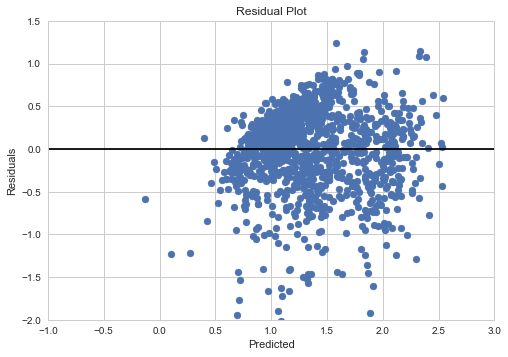

In [77]:
plt.scatter(linear.predict(X_val), linear.predict(X_val)-y_val)
plt.xlim(-1,3)
plt.ylim(-2,1.5)
plt.axhline(y=0,color='black')
plt.title('Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

## Gradient Boosting Model

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

X = data.drop('ROI', 1)
y = data['ROI']
gbm = GradientBoostingRegressor(learning_rate = 0.01,max_leaf_nodes=512)
gbm = gbm.fit(X, y)
importance = gbm.feature_importances_

feature_dict = dict(zip(data.columns, importance))
feature_dict = sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=1)
feature_dict

[('UG', 0.33275889563184835),
 ('HIGHDEG', 0.21358907579719436),
 ('LOCALE', 0.13395115066773677),
 ('UGDS_MEN', 0.08181946654932137),
 ('C100_4', 0.0520104364636931),
 ('UG_NRA', 0.04079937021360919),
 ('SCH_DEG', 0.03943495630156372),
 ('REGION', 0.03869559820632707),
 ('MEDIAN_HH_INC', 0.012938499802784022),
 ('LONGITUDE', 0.00979112149705782),
 ('UGDS_WOMEN', 0.008261469965613394),
 ('MAIN', 0.005309547282056483),
 ('AVGFACSAL', 0.0048919885177605635),
 ('UG_BLACKNH', 0.004254846215717503),
 ('NUMBRANCH', 0.0036416097181601113),
 ('UG_WHITENH', 0.0036032835956017386),
 ('UNEMP_RATE', 0.003397615106684194),
 ('UG_AIANOLD', 0.0032881452763442514),
 ('LATITUDE', 0.0031582356268572832),
 ('ST_FIPS', 0.0020508880162181985),
 ('UG_UNKN', 0.0015470112570442468),
 ('UG_HISPOLD', 0.0008067882908062636),
 ('PFTFAC', 0.0),
 ('ICLEVEL', 0.0),
 ('UG_API', 0.0)]

### LightGBM by Microsoft

In [78]:
import lightgbm as lgb

X = data.drop('ROI', 1)
y = data['ROI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=['REGION', 'LOCALE', 'SCH_DEG', 'MAIN', 
                                                               'HIGHDEG', 'ST_FIPS', 'ICLEVEL'], free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [81]:
params = {
 'task': 'train',
 'objective':'regression',
 'verbose': 1,
 'max_bin': 256,  # 大会有更准的效果,更慢的速度
 'learning_rate': 0.01,  # 学习率
 'num_leaves': 512,  # 大会更准,但可能过拟合
 'num_iterations': 1000,
 'early_stopping_round': 10,
}

In [80]:
gbm = lgb.train(params,
                    lgb_train, valid_sets = [lgb_eval], verbose_eval = False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['HIGHDEG', 'ICLEVEL', 'LOCALE', 'MAIN', 'REGION', 'SCH_DEG', 'ST_FIPS']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [85]:
score = np.zeros([5, 5, 5, 5])

In [86]:
num_leaves = [50, 100, 200, 300, 400]
min_data_in_leaf = [10, 20, 30, 40, 50]
max_depth = [10, 15, 20, 50, 100]
learning_rate = [0.0001,0.0005, 0.001,0.005, 0.01]

In [87]:
param = [((ia, ib, ic, iid), (a, b, c, d)) for ia, a in enumerate(num_leaves) 
        for ib, b in enumerate(min_data_in_leaf)
        for ic, c in enumerate(max_depth)
        for iid, d in enumerate(learning_rate)]

In [ ]:
# Don't run
# Takes 40 mins to do grid search
for (ia, ib, ic, iid), (a, b, c, d) in tqdm(param):
    params = {
     'task': 'train',
     'objective':'regression',
     'metric': 'l2_root',
     'verbose': 0,

     'max_bin': 128,  # 大会有更准的效果,更慢的速度
     'learning_rate': d,  # 学习率
     'num_leaves': a,  # 大会更准,但可能过拟合
     'num_iterations': 1000,
     'early_stopping_round': 5,
     'min_data_in_leaf': b,
     'max_depth': c,
    }
#     print('Running {}-{}-{}, {}/343'.format(ia, ib, ic, (ia)*49 + (ib) * 7 + ic + 1))
    gbm = lgb.train(params,
                    lgb_train, valid_sets = [lgb_eval], verbose_eval = False)
    score[ia, ib, ic] = gbm.best_score['valid_0']['rmse']
#     print('Score is {}'.format(gbm.best_score['valid_0']['l2_root']))

In [98]:
score_new = score

In [96]:
for ia, a in enumerate(num_leaves):
    print(ia,a)

0 50
1 100
2 200
3 300
4 400


Text(0,0.5,'RMSE')

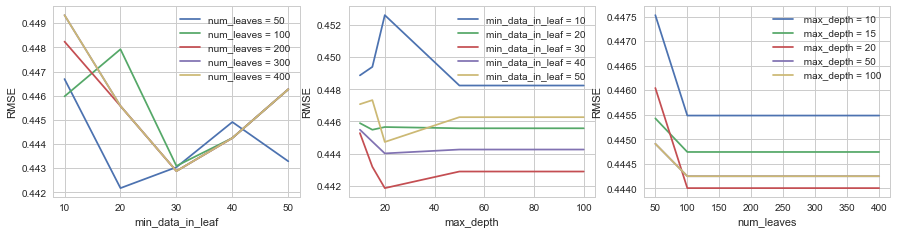

In [145]:
# from matplotlib import rc
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.figure(figsize=(15, 3.5))
# Subplot 1
plt.subplot(1, 3, 1)
for ia, a in enumerate(num_leaves):
    plt.plot(min_data_in_leaf, score_new[ia, :, 3, 3], label = 'num_leaves = ' + str(a))
plt.legend()
plt.xlabel('min_data_in_leaf')
plt.ylabel('RMSE')

# Subplot 2
plt.subplot(1, 3, 2)
for ia, a in enumerate(min_data_in_leaf):
    plt.plot(max_depth, score_new[2, ia, :, 2], label = 'min_data_in_leaf = ' + str(a))
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# Subplot 3
plt.subplot(1, 3, 3)
for ia, a in enumerate(max_depth):
    plt.plot(num_leaves, score_new[:, 3, ia, 3], label = ' max_depth = ' + str(a))
plt.legend()
plt.xlabel('num_leaves')
plt.ylabel('RMSE')



Text(0,0.5,'RMSE')

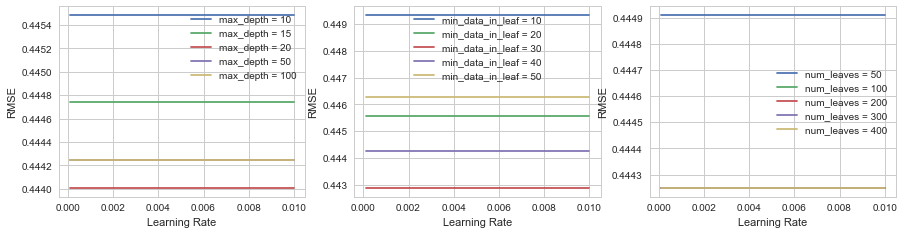

In [144]:
plt.figure(figsize=(15, 3.5))
# Subplot 4
plt.subplot(1, 3, 1)
for ia, a in enumerate(max_depth):
    plt.plot(learning_rate, score_new[3, 3, ia, :], label = 'max_depth = ' + str(a))
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
# plt.savefig('./hyper.eps')

# Subplot 5
plt.subplot(1, 3, 2)
for ia, a in enumerate(min_data_in_leaf):
    plt.plot(learning_rate, score_new[3, ia, 3, :], label = 'min_data_in_leaf = ' + str(a))
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')

# Subplot 6
plt.subplot(1, 3, 3)
for ia, a in enumerate(num_leaves):
    plt.plot(learning_rate, score_new[ia, 3, 3, :], label = 'num_leaves = ' + str(a))
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')

### Best Model

In [137]:
params = {
     'task': 'train',
     'objective':'regression',
     'metric': 'l2_root',
     'verbose': 0,
     'max_bin': 128,  
     'learning_rate': 0.01,  
     'num_leaves': 50,
     'num_iterations': 1000,
     'early_stopping_round': 10,
     'min_data_in_leaf': 20,
     'max_depth': -1,
    }
#     print('Running {}-{}-{}, {}/343'.format(ia, ib, ic, (ia)*49 + (ib) * 7 + ic + 1))
gbm = lgb.train(params,
                lgb_train, valid_sets = [lgb_eval], verbose_eval = False)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [138]:
score = gbm.best_score['valid_0']['rmse']

In [139]:
score

0.44217374726648007

In [140]:
gbm.feature_importance()

array([1039,  826,   39,  541,  493,  137,  608,  562, 1272, 1376,  740,
        508, 1883,  991,  600, 1096,  951,  919,  860,  808, 1365, 1101,
       2434, 2224])

In [141]:
y_labels = [gbm.feature_name()[i] for i in np.argsort(gbm.feature_importance())]

In [142]:
y_labels

['REGION',
 'MAIN',
 'SCH_DEG',
 'ICLEVEL',
 'LOCALE',
 'HIGHDEG',
 'UG_UNKN',
 'NUMBRANCH',
 'PFTFAC',
 'UG_HISPOLD',
 'LONGITUDE',
 'UG_AIANOLD',
 'UG_API',
 'UG_BLACKNH',
 'UG_NRA',
 'LATITUDE',
 'UG_WHITENH',
 'UNEMP_RATE',
 'ST_FIPS',
 'MEDIAN_HH_INC',
 'AVGFACSAL',
 'UG',
 'C100_4',
 'UGDS_WOMEN']

<BarContainer object of 5 artists>

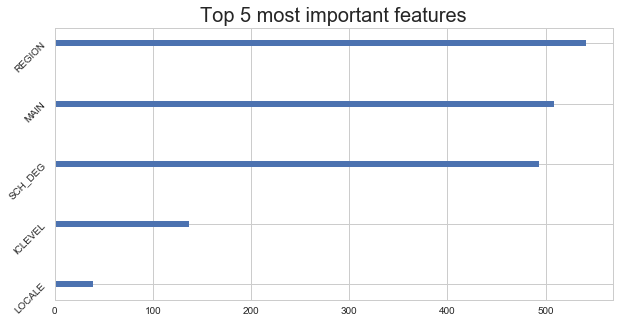

In [186]:
plt.figure(figsize=(10, 5))
axes = plt.gca()
axes.set_yticklabels([''] + ['LOCALE', 'ICLEVEL','SCH_DEG','MAIN', 'REGION'])
plt.yticks(rotation = 45)
plt.title('Top 5 most important features', fontsize = 20)
plt.barh(range(5), sorted(gbm.feature_importance())[:5],height = 0.1)